<a href="https://colab.research.google.com/github/shubham1m/MusicGeneration/blob/main/MusicWithMuseGAN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install music21==5.3.0

     |████████████████████████████████| 18.0MB 1.2MB/s 
  Created wheel for music21: filename=music21-5.3.0-cp37-none-any.whl size=21291740 sha256=b4adde902df097f8513fc5ca2a36744124e12f7fbfe5d1a93583376f9fb63900
  Stored in directory: /root/.cache/pip/wheels/53/8b/a6/be1921c60a68f0bea31c6b6a0a7b125badd61294d6a694407f
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond #> /dev/null

# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth #> /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

installing lilypond...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono ghostscript gsfonts
  libauthen-sasl-perl libcupsfilters1 libcupsimage2 libdata-dump-perl
  libencode-locale-perl libfile-listing-perl libfont-afm-perl libgs9
  libgs9-common libhtml-form-perl libhtml-format-perl libhtml-parser-perl
  libhtml-tagset-perl libhtml-tree-perl libhttp-cookies-perl
  libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl libijs-0.35 libio-html-perl libio-socket-ssl-perl
  libjbig2dec0 libkpathsea6 liblwp-mediatypes-perl liblwp-protocol-https-perl
  libmailtools-perl libnet-http-perl libnet-smtp-ssl-perl libnet-ssleay-perl
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libte

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import types

!cp /content/drive/MyDrive/ColabNotebooks/models/MuseGAN.py .
from MuseGAN import MuseGAN

!cp /content/drive/MyDrive/ColabNotebooks/utils/loaders.py .
from loaders import load_music

import music21
from music21 import midi
from music21 import note, stream, duration

from IPython.display import Image, Audio

In [ ]:
!fluidsynth --version
print('-------------------------')
!lilypond --version
print('-------------------------')
music21.__version__

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

FluidSynth 1.1.9
-------------------------
GNU LilyPond 2.18.2

Copyright (c) 1996--2012 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.

-------------------------


'5.3.0'

In [ ]:
import tensorflow
tensorflow.keras.__version__ #2.4.0

'2.4.0'

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(filename + '.wav'))

In [ ]:
# run params
SECTION = '/content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithMuseGAN_Data'
RUN_ID = '0017'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = '{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])



if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    os.mkdir(os.path.join(RUN_FOLDER, 'samples'))

mode =  'build' # ' 'load' #

#Load Data

In [ ]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(RUN_FOLDER, FILENAME, n_bars, n_steps_per_bar)
data_binary = np.squeeze(data_binary)

#Build Model

In [ ]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:                 
    gan.load_weights(RUN_FOLDER)

In [ ]:
gan.chords_tempNetwork.summary()

Model: "temporal_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
temporal_input (InputLayer)  [(None, 32)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 1, 1024)        66560     
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 1, 1024)        4096      
_________________________________________________________________
activation (Activation)      (None, 2, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 2, 1, 32)          32800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 1, 32)     

In [ ]:
gan.barGen[0].summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bar_generator_input (InputLa [(None, 128)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_10 (Activation)   (None, 1024)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 2, 1, 512)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 4, 1, 512)         524800    
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 1, 512)         2048

In [ ]:
gan.generator.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       [(None, 4, 32)]      0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       [(None, 32)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           melody_input[0][0]               
___________________________________________________________________________________________

In [ ]:
gan.critic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 2, 16, 84, 4)]    0         
_________________________________________________________________
conv3d (Conv3D)              multiple                  1152      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv3d_1 (Conv3D)            multiple                  16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
conv3d_2 (Conv3D)            multiple                  196736    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0     

#Training

In [ ]:
EPOCHS = 6000
gan.epoch = 0

In [ ]:
gan.train(     
    data_binary
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
)

0 (5, 1) [D loss: (9.3)(R -0.6, F 0.0, G 1.0)] [G loss: -0.0]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1 (5, 1) [D loss: (-243.2)(R -288.6, F -2.1, G 4.7)] [G loss: -35.6]
2 (5, 1) [D loss: (-283.7)(R -553.3, F -15.5, G 28.5)] [G loss: -182.0]
3 (5, 1) [D loss: (-326.7)(R -482.9, F 5.1, G 15.1)] [G loss: -252.4]
4 (5, 1) [D loss: (-318.1)(R -643.0, F 9.1, G 31.6)] [G loss: 6.3]
5 (5, 1) [D loss: (-295.7)(R -595.0, F 123.5, G 17.6)] [G loss: -583.4]
6 (5, 1) [D loss: (-240.3)(R -669.7, F 200.4, G 22.9)] [G loss: -459.4]
7 (5, 1) [D loss: (-183.4)(R -531.0, F 223.2, G 12.4)] [G loss: -466.3]
8 (5, 1) [D loss: (-119.6)(R -456.5, F 255.0, G 8.2)] [G loss: -424.2]
9 (5, 1) [D loss: (-67.0)(R -354.5, F 246.7, G 4.1)] [G loss: -369.5]
10 (5, 1) [D loss: (-40.5)(R -210.0, F 160.2, G 0.9)] [G loss: -265.5]
11 (5, 1) [D loss: (-19.1)(R -278.6, F 240.7, G 1.9)] [G loss: -261.2]
12 (5, 1) [D loss: (-4.1)(R -88.4, F 83.2, G 0.1)] [G loss: -105.3]
13 (5, 1) [D loss: (-33.9)(R -99.8, F 62.3, G 0.4)] [G loss: 73.9]
14 (5, 1) [D loss: (-59.3)(R -76.0, F -0.3, G 1.7)] [G loss: 375.9]
15 (5, 1) [D loss: (

KeyboardInterrupt: ignored

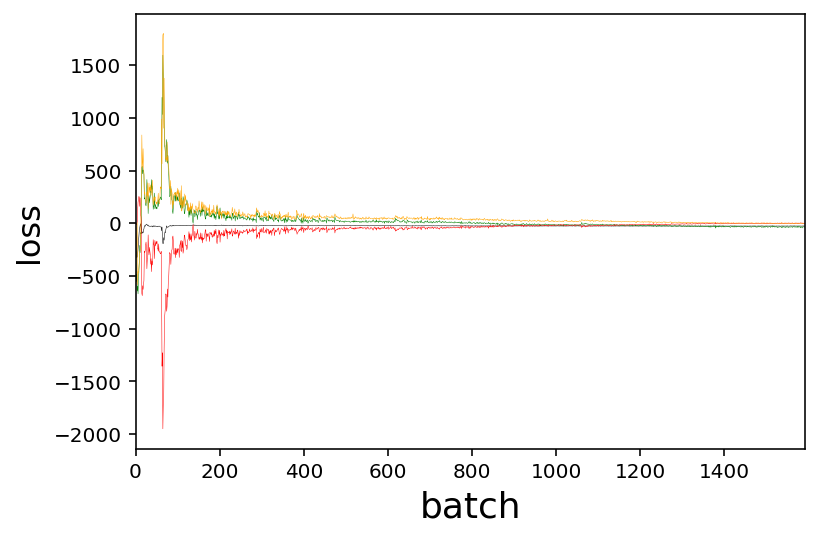

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, len(gan.d_losses))
# plt.ylim(0, 2)

plt.show()